In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**importing important libraries**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import re
from os import path
from PIL import Image
from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy

In [ ]:
# importing nltk related packages
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('treebank')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

**importing data**

note: make sure to change the file path for different users

In [ ]:
disney_filepath = '/content/gdrive/MyDrive/Fall 2021/CS 331/Final Project/data/disney_data.json'

disney = pd.read_json(disney_filepath, lines=True)

In [ ]:
marvel_filepath = '/content/gdrive/MyDrive/Fall 2021/CS 331/Final Project/data/marvel_data2.json'

marvel = pd.read_json(marvel_filepath, lines=True)

**named entity recognition**

In [ ]:
# model that extracts named entities from the plots of movies
# example: for the plot of finding nemo, we would expect Dory, Marlin and Nemo to be some of the outputs of this model

def ner_model(sentence):
  entities = []

  for sent in nltk.sent_tokenize(sentence):
    for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):

      if hasattr(chunk, 'label'):
        string = ' '.join(c[0] for c in chunk)

        # get rid of the duplicates
        if string not in entities: 
          entities.append(string)

  return entities

testing ner

In [ ]:
print(ner_model(disney.loc[110,'Plot']))
print(ner_model(disney.loc[101,'Plot']))
print(ner_model(disney.loc[95,'Plot']))
print(ner_model(disney.loc[118,'Plot']))
print(ner_model(disney.loc[1,'Plot']))

['Dory', 'Nemo', 'Marlin', 'Marine Life Institute']
['Fearless', 'Anna', 'Kristoff', 'Sven', 'Elsa', 'Arendelle', 'Olaf']
['Scotland', 'Princess Merida', 'Kelly Macdonald', 'Queen Elinor', 'Dame Emma Thompson', 'Merida']
['Africa', 'Simba', 'Queen Sarabi', 'Mufasa', 'Nala', 'Scar']
['Snow White', 'Magic Mirror', 'Doc', 'Sneezy', 'Grumpy', 'Happy', 'Bashful', 'Sleepy', 'Dopey']


**topic modeling**

In [ ]:
model = spacy.load('en_core_web_sm')

In [ ]:
# model that returns the major topics of a certain plot
# this model only includes nouns, but it can be edited to include other parts of speech

def topic_model(sentence):

  # create the spacy model
  doc = model(sentence)
  pos_list = ['NOUN']

  preproc_text = []
  preproc_sent = []

  for token in doc:
    # if not end of sentence
    if token.text != '.':
      if not (token.is_stop) and not(token.is_punct) and token.pos_ in pos_list:
        preproc_sent.append(token.lemma_)
    else:
      preproc_text.append(preproc_sent)
      preproc_sent = []
    
  preproc_text.append(preproc_sent)

  # get rid of empty lists
  preproc_text = [x for x in preproc_text if x]

  # create one master list of topics without duplicates
  final_topics = []
  for sent in preproc_text:
    for word in sent:
      if word not in final_topics:
        final_topics.append(word)
  
  return final_topics

topic modeling testing

In [ ]:
print(topic_model(disney.loc[101, 'Plot']))

['optimist', 'team', 'mountain', 'man', 'reindeer', 'journey', 'sister', 'icy', 'power', 'kingdom', 'winter', 'condition', 'troll', 'snowman', 'battle', 'element', 'race', 'reality', 'fear', 'secret', 'ice', 'snow', 'ability', 'moment', 'magic', 'minute', 'emotion', 'monster']


**word cloud**

In [ ]:
# this creates a word cloud based on a given plot

def create_word_cloud(text):
  wordcloud = WordCloud(background_color="white").generate(text)

  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

testing word cloud

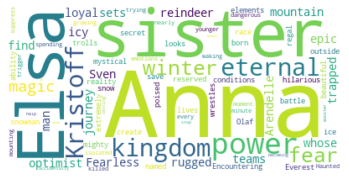

In [ ]:
text = disney.Plot[101]
create_word_cloud(text)

**year and decade**

In [ ]:
# returns the year of release
def get_year(df, loc):
  return df.Year[loc]

In [ ]:
# returns the decade of release
def get_decade(df, loc):
  year = get_year(df,loc)
  return year - (year%10)

testing

In [ ]:
print(get_year(disney, 101))
print(get_decade(disney, 101))

2013
2010


**genre**

In [ ]:
# returns the genres of the movie in a stemmed form to help with comparison

def get_genre(df, loc):
  genre = df.Genre[loc]

  # clean the text
  genre = genre.lower()
  genre = "".join([char for char in genre if char not in string.punctuation])
  words = word_tokenize(genre)
  porter = PorterStemmer()
  stemmed = [porter.stem(word) for word in words]

  # not lemma because then animated and animation don't come up with the same thing

  return stemmed

testing

In [ ]:
print(get_genre(disney, 101))

['anim', 'adventur', 'comedi']


**actors**

In [ ]:
# returns the list of actors

def get_actors(df, loc):
  actor = df.Actors[loc]

  # clean the text
  actor = actor.lower()
  actors = re.split(r'[.,]', actor)

  final_actors = []
  for actor in actors:
    # get rid of leading whitespace
    final_actors.append(actor.lstrip())

  return final_actors

testing

In [ ]:
print(get_actors(disney, 101))

['kristen bell', 'idina menzel', 'jonathan groff']


**directors**

In [ ]:
# returns the director(s)

def get_directors(df, loc):
  director = df.Director[loc]

  # clean the text
  director = director.lower()
  directors = re.split(r'[.,]', director)

  final_directors = []
  for director in directors:
    # get rid of leading or trailing whitespace
    final_directors.append(director.lstrip())

  return final_directors

testing

In [ ]:
print(get_directors(disney, 101))
print(get_directors(disney,0))

['chris buck', 'jennifer lee']
['n/a']


**production**

In [ ]:
# returns the production studio in a list of tokenized words

def get_production(df, loc):
  production = df.Production[loc]

  # clean the text
  production = production.lower()
  production = "".join([char for char in production if char not in string.punctuation])
  production = word_tokenize(production)

  return production

testing

In [ ]:
print(get_production(disney, 4))
print(get_production(disney, 101))

['walt', 'disney', 'productions']
['na']


**tfidf**

In [ ]:
# get the tfidf vector for a specific plot

def get_tfidf(df, loc):
  vectorizer = TfidfVectorizer()
  X = vectorizer.fit_transform(df['Plot'])
  return X[loc]

although this next part is more on the side of implementation, it is necessary for testing the previous code

In [ ]:
# find the cosine similarity between a certain query and all possible plots

def cosine_sim(df, query):
  vectorizer = TfidfVectorizer()
  X = vectorizer.fit_transform(df['Plot'])
  query_vector = vectorizer.transform([query])
  results = cosine_similarity(X,query_vector)

  return results

In [ ]:
# find the plot with the highest similarity to the query

def find_highest_cos_sim(results):
  i = 0
  current_largest = 0
  index_largest = 0
  for result in results:
    if result[0] > current_largest:
      index_largest = i
      current_largest = result[0]
    i += 1
  return index_largest

testing

In [ ]:
frozen_vec = get_tfidf(disney,101)
query = 'olaf princess monster mountain sister'
results = cosine_sim(disney, query)
index_largest = find_highest_cos_sim(results)

print(disney.Title[index_largest])

Frozen


**output**

In [ ]:
# create the output row for a given movie

def get_row(df, loc):
  row = [df.Title[loc], get_year(df, loc), get_decade(df, loc), get_genre(df, loc), get_actors(df, loc), ner_model(df.Plot[loc]), get_directors(df,loc), topic_model(df.Plot[loc]), get_tfidf(df, loc), get_production(df, loc)]
  return row

In [ ]:
# create the final output dataframe that will then be used to implement the search algorithm

def create_output(df):
  rows = []
  for index, row in df.iterrows():
    rows.append(get_row(df, index))
  final_dataframe = pd.DataFrame(rows, columns=["title", "year", "decade", "genre", "actors", "named entities", "director", "plot topics", "tfidf vector", "production"])
  return final_dataframe

testing

In [ ]:
df = create_output(disney)
df.head()

,title,year,decade,genre,actors,named entities,director,plot topics,tfidf vector,production
0,Academy Award Review of Walt Disney Cartoons,1937,1930,"[anim, short, comedi]","[billy bletcher, dorothy compton, eddie holden]","[Disney, Snow White, Seven Dwarfs]",[n/a],"[compilation, short, release]","(0, 8)\t0.26253361164209704\n (0, 863)\t0.2...",[na]
1,Snow White and the Seven Dwarfs,1937,1930,"[anim, famili, fantasi]","[adriana caselotti, harry stockwell, lucille l...","[Snow White, Magic Mirror, Doc, Sneezy, Grumpy...","[william cottrell, david hand, wilfred jackson]","[charm, creature, kingdom, stepmother, forest,...","(0, 226)\t0.13579487920663044\n (0, 449)\t0...",[na]
2,Pinocchio,1940,1940,"[anim, adventur, comedi]","[dickie jones, christian rub, mel blanc]","[Inventor, Gepetto, Pinocchio, Jiminy Cricket,...","[norman ferguson, t, hee, wilfred jackson]","[marionette, wish, boy, fairy, conscience, tro...","(0, 2707)\t0.14607432597135594\n (0, 1067)\...","[walt, disney, productions]"
3,Fantasia,1940,1940,"[anim, famili, fantasi]","[leopold stokowski, deems taylor, the philadel...","[Disney, Western, Leopold Stokowski, Philadelp...","[james algar, samuel armstrong, ford beebe jr, ]","[animator, picture, music, magician, limit, st...","(0, 718)\t0.07697953789902512\n (0, 1977)\t...",[na]
4,The Reluctant Dragon,1941,1940,"[anim, comedi, famili]","[robert benchley, frances gifford, buddy pepper]","[Humorist, Robert Benchley, Walt Disney, Walt ...","[alfred l, werker, hamilton luske, jack cutting]","[story, dragon, poetry, way, tour, animation, ...","(0, 2257)\t0.17626133935877134\n (0, 139)\t...","[walt, disney, productions]"


In [ ]:
marvel_output = create_output(marvel)
marvel_output.head()

,title,year,decade,genre,actors,named entities,director,plot topics,tfidf vector,production
0,Iron Man,2008,2000,"[action, adventur, scifi]","[robert downey jr, , gwyneth paltrow, terrence...","[Tony, Stark, Genius, Son, Howard Stark, Tony ...",[jon favreau],"[genius, billionaire, playboy, philanthropist,...","(0, 480)\t0.0849488237183066\n (0, 546)\t0....",[na]
1,The Incredible Hulk,2008,2000,"[action, adventur, scifi]","[edward norton, liv tyler, tim roth]","[Gamma Bomb, Incredible Hulk, Bruce Banner, Wh...",[louis leterrier],"[event, story, cure, condition, monster, stres...","(0, 5)\t0.14475904893624333\n (0, 251)\t0.1...",[na]
2,Iron Man 2,2010,2010,"[action, adventur, scifi]","[robert downey jr, , mickey rourke, gwyneth pa...","[Iron Man, Tony Stark, Stark, Pepper Potts, Ja...",[jon favreau],"[world, life, superhero, billionaire, inventor...","(0, 254)\t0.13951498897824108\n (0, 580)\t0...",[na]
3,Thor,2011,2010,"[action, adventur, fantasi]","[chris hemsworth, anthony hopkins, natalie por...","[Chris Hemsworth, Asgard, Odin, Sir Anthony Ho...",[kenneth branagh],"[warrior, realm, father, arrogance, human, lov...","(0, 776)\t0.15241124601701905\n (0, 305)\t0...",[na]
4,Captain America: The First Avenger,2011,2010,"[action, adventur, scifi]","[chris evans, hugo weaving, samuel l, jackson]","[America, Steve Rogers, Rogers, Nazi Germany, ...",[joe johnston],"[sickly, service, change, courage, wit, consci...","(0, 21)\t0.06665490114181342\n (0, 129)\t0....",[na]
